# Early cancer detection using signature framework

On essaie ici de différentier les dynamiques malignes des dynamiques bénignes pour les biomarqueurs.

In [1]:
! apt-get install git
!git clone https://github.com/RemiVaucher/Thesis

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'Thesis'...
remote: Enumerating objects: 457, done.
remote: Total 457 (delta 0), reused 0 (delta 0), pack-reused 457 (from 1)
Receiving objects: 100% (457/457), 282.23 MiB | 12.11 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (420/420), done.


In [ ]:
!pip install gudhi
!pip install signatory
!pip install iisignature
!pip install giotto-tda

In [ ]:
import signatory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gudhi
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.cover_complex import MapperComplex, GraphInducedComplex, NerveComplex
import networkx as nx
from gtda.mapper import *
from sklearn.cluster import DBSCAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import sys
%cd Thesis/Chapter4/Oncology/TDA/

from TDA_utils import corr_metric, compute_complex



/content/Thesis/Chapter4/Oncology/TDA


ModuleNotFoundError: No module named 'gudhi'

On importe les données bénignes:

In [ ]:
if local:
  path = 'G://Mon Drive/Etude_Cancer/TDA/Simul/benign_dwi_b'
else:
  path = "./Simul/benign_dwi_b"


data = {}
for b in [0.1,0.12,0.14,0.17]:
  df = pd.read_csv(path+str(b)+".csv",sep = ";")
  df_numpy = df.to_numpy().T[:,:,None]
  data[str(b)]= torch.tensor(pd.read_csv(path+str(b)+".csv",sep = ";").to_numpy().T[1:,:,None])

In [ ]:
data['0.14'].shape

torch.Size([1000, 7, 1])

<ipython-input-5-41da20170ac6>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  data_ben= (data_ben.T-data_ben.mean(axis=1)[:,0]).T


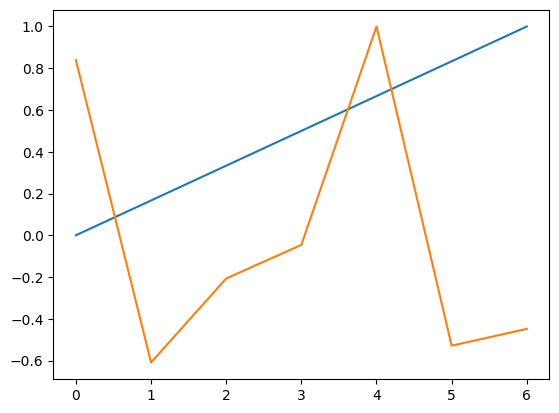

In [ ]:
scale = True
Time = True

data_ben = torch.cat((data['0.1'][:,1:],data['0.12'][:,1:],data['0.14'][:,1:],data['0.17'][:,1:]))
data_ben= (data_ben.T-data_ben.mean(axis=1)[:,0]).T
if scale:
  data_ben = data_ben/np.abs(data_ben[:,:,0]).max(dim = 1)[0][:,None,None]

time = torch.tensor([300*i for i in range(7)])[None,:,None]/1800
times = time.repeat(data_ben.shape[0],1,1)
if Time:
  data_ben= torch.cat((times,data_ben),axis = -1)

plt.plot(data_ben[0,:])

In [ ]:
import os
import re


def starts_with_benign(s):
    return s.startswith("benign")
def starts_with_des(s):
    return s.startswith("desk")
classif = []
data_ben_mal = {}
if local:
  directory = 'G://Mon Drive/Etude_Cancer/TDA/Simul/'
else:
  directory = "./Simul/"

for filename in os.listdir(directory):
    if starts_with_benign(filename) or starts_with_des(filename):
      i = 1
    else:
      f = os.path.join(directory, filename)
      data_ben_mal[filename]= torch.tensor(pd.read_csv(f,sep = ";").to_numpy().T[1:,:,None])



In [ ]:
data_mal = torch.cat(tuple([data_ben_mal[filename] for filename in data_ben_mal.keys()]))
data_mal[:,:,0] = (data_mal[:,:,0].T-data_mal[:,:,0].mean(axis=1)).T
if scale:
  data_mal = data_mal/np.abs(data_mal[:,:,0]).max(dim = 1)[0][:,None,None]

time = torch.tensor([300*i for i in range(7)])[None,:,None]/1800
times = time.repeat(data_mal.shape[0],1,1)
if Time:
  data_mal = torch.cat((times,data_mal),axis = -1)



In [ ]:
rang = 100

idx = [i for i in range(rang)]
list_samples = [0,1,2,3,4,5,6,7,8]
for k in range(20):
  idx += [i+k*1000 for i in range(rang)]
idx = np.array(idx)

classe = [-1 for i in range(4*rang)]
for k in range(21-4):
  classe += [k%6 for i in range(rang)]

classe = np.array(classe)

data_all = torch.cat((data_ben,data_mal))[idx,:]



In [ ]:
TD = TimeDelayEmbedding(dim=4,delay=1,skip = 1)
test = torch.tensor(TD.transform(data_all))

<ipython-input-9-f937322f4f46>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  test = torch.tensor(TD.transform(data_all))


In [ ]:
test[0]

tensor([[ 0.0000,  0.8391,  0.1667, -0.6092],
        [ 0.1667, -0.6092,  0.3333, -0.2069],
        [ 0.3333, -0.2069,  0.5000, -0.0460],
        [ 0.5000, -0.0460,  0.6667,  1.0000],
        [ 0.6667,  1.0000,  0.8333, -0.5287],
        [ 0.8333, -0.5287,  1.0000, -0.4483]], dtype=torch.float64)

In [ ]:
depth = 2

sig = signatory.Signature(depth = depth)
logsig = signatory.LogSignature(depth = depth)
signatures = sig(data_all,basepoint = True)
logsignatures = logsig(data_all,basepoint = True)


from group_mean import mean as sig_mean

#bar_sig = sig_mean(signatures.numpy(), channels = 2, depth = 3)
bar_sig = np.zeros((1,signatures.shape[-1]))

In [ ]:
signatures.shape

torch.Size([450, 14])

In [ ]:
signatures[0]

tensor([-0.5287, -0.4483,  0.1398, -1.1175,  1.3545,  0.1005, -0.0246, -0.2432,
         1.0774,  0.4530, -0.8968, -0.4051, -0.1011, -0.0150],
       dtype=torch.float64)

In [ ]:
M

array([ 7.68494717e-02,  7.36686195e-01,  2.95292091e-03, -3.13623577e-01,
        3.70237522e-01,  2.71353273e-01,  7.56431454e-05,  3.17949956e-03,
       -3.04608065e-02, -1.34591970e-01,  2.94566829e-02,  3.81417810e-02,
        1.17303545e-01,  6.66340698e-02,  1.45421064e-06, -2.72221882e-02,
        8.19109050e-02,  1.10629853e-02, -8.30813528e-02,  2.70539020e-02,
       -5.95231965e-02, -4.34070459e-02,  2.84483613e-02, -4.68375805e-02,
        6.95524320e-02,  3.10690930e-02, -5.07259648e-04, -1.70198323e-02,
        3.44785785e-02,  1.22721049e-02,  2.22335603e-08,  2.99383303e-04,
       -3.28954519e-03, -1.27888595e-02,  8.08172258e-03,  2.82826963e-02,
        1.09340651e-02,  5.23614619e-03, -7.51606814e-03, -9.11210284e-03,
       -3.62621103e-02, -1.42750730e-02,  4.90982731e-03,  5.36195491e-02,
       -5.31525801e-02, -1.14220342e-02,  2.42557821e-03, -1.36470866e-02,
        4.64539160e-02,  6.71657895e-03, -2.56503280e-02, -5.87587177e-02,
        6.19882728e-02,  

In [ ]:
from group_mean import mean as smean

M = smean(signatures[:4000].numpy(),channels = 2, depth = depth)

height = lambda S : np.linalg.norm(S)
height2 = lambda S : np.linalg.norm(S-M)
def LevyArea(s):
  return(0.5*(s[3]-s[4]))
def LogLevyArea(ls):
  return ls[2]

In [ ]:
import sklearn.cluster as cls
print(logsignatures.shape)
n_interval = 1000
pipe = make_mapper_pipeline(filter_func = LevyArea, cover = CubicalCover(n_intervals=n_interval, overlap_frac=0.8),clusterer = DBSCAN(eps=0.5),n_jobs = 1, contract_nodes= True) #
graph = pipe.fit_transform(signatures)

torch.Size([2100, 3])


In [ ]:
import plotly.express as px
cover = True
mapper = True
print(signatures.shape)
if cover:
  if mapper:
    plotly_params = {"node_trace": {"marker_colorscale":"Jet"}}
    fig = plot_static_mapper_graph(pipe,signatures,color_data=classe,plotly_params = plotly_params,layout="mds")
    fig.update_layout(
    #title=dict(text=r"$\textbf{Nerve complex with lens: } LevyArea(X)$")
)
    fig.show()
  else:
    #kamada_kawai
    plt.figure()
    nx.draw(G, pos = nx.spectral_layout(G), node_color = [comp.node_info_[v]["colors"][0] for v in G.nodes()])
else:

  from gudhi.representations import BettiCurve, Landscape

  LS = gudhi.representations.Landscape(resolution = 1000)
  L = LS.fit_transform([comp.persistence_intervals_in_dimension(1)])

  plt.plot(L[0])
  plt.title("Landscape")
  plt.show()

  BC= BettiCurve()
  bc= BC.fit_transform([pers0])
  plt.plot(bc.T)
  plt.show()

  BC1= BettiCurve()
  bc1= BC1.fit_transform([pers1])
  plt.plot(bc1.T)
  plt.show()

  gudhi.plot_persistence_diagram(pers)

  gudhi.plot_persistence_barcode(pers)

torch.Size([2100, 6])


In [ ]:

if cover:
  if mapper:
    for i in range(len(graph.vs["node_elements"])):
      print(f"""
      Node id : {i}
      Size cluster : {len(graph.vs["node_elements"][i])}
      With element : {graph.vs["node_elements"][i]}
      """)
  else:
    G = comp.get_networkx()

else:
  _ = comp.compute_persistence()
  betti = comp.betti_numbers()
  pers = comp.persistence()
  pers0 = comp.persistence_intervals_in_dimension(0)
  pers1 = comp.persistence_intervals_in_dimension(1)




      Node id : 0
      Size cluster : 5
      With element : [  0  50 100 150 248]
      

      Node id : 1
      Size cluster : 8
      With element : [  1 101 226 241 328 439 447 489]
      

      Node id : 2
      Size cluster : 6
      With element : [  1 101 328 439 447 489]
      

      Node id : 3
      Size cluster : 2
      With element : [  2 102]
      

      Node id : 4
      Size cluster : 3
      With element : [  3 103 202]
      

      Node id : 5
      Size cluster : 17
      With element : [  4 104 394 456 487 602 607 617 627 630 632 633 645 646 667 676 679]
      

      Node id : 6
      Size cluster : 8
      With element : [  4 104 394 456 487 617 646 676]
      

      Node id : 7
      Size cluster : 2
      With element : [  5 105]
      

      Node id : 8
      Size cluster : 2
      With element : [  6 106]
      

      Node id : 9
      Size cluster : 3
      With element : [  7 107 313]
      

      Node id : 10
      Size cluster : 4
      With e

In [ ]:
if not mapper:
  for nodes in G.nodes():
   print(nodes)

In [ ]:
print(signatures.shape)
print(classe)

torch.Size([1050, 14])
[-1 -1 -1 ... 16 16 16]
